필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

In [3]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.preprocessing import StandardScaler

데이터 가져오기

In [5]:
base_path = r"C:\Users\owner\Desktop\water-source\data"

In [6]:
scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [7]:
print(type(scb_yearly))  # type-dict
print(scb_yearly.keys())  # 2012년부터 2022년까지

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])


In [8]:
scb_yearly['2012년'].columns

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')

2013년 자료부터

In [9]:
scb_yearly_df13 = pd.DataFrame()

for item in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[item]])

In [10]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

결측치 확인

In [11]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


In [12]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

In [13]:
scb_yearly_df13.head()

,측정일/월,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00h,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01h,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02h,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8
3,2013-01-01 03h,용봉,4.1,6.9,375.0,11.4,2.5,NaN,NaN,6.9
4,2013-01-01 04h,용봉,4.0,6.9,380.0,11.3,2.6,NaN,NaN,6.9


유량 데이터 추가하기

In [14]:
scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=True)  # index_col = 0을 제외함

In [15]:
for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['연월일시'] = scb_flow_yearly[year]['시간'].apply(lambda x : x[:-3])

In [16]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('연월일시').mean()

In [17]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [18]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [19]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [20]:
print(scb_flow_yearly_hour_df.__len__())
print(scb_yearly_df13.__len__())

84393
82257


In [21]:
scb_yearly_df13['연월일시'] = scb_yearly_df13['측정일/월'].transform(lambda x: x.strip('h').replace('-', '.'))

In [22]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [23]:
scb_data = scb_data[:82257]

In [24]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11   상류수위(EL.m)  82231 non-null  float64
 12   하류수위(EL.m)  82231 non-null  float64
 13   유입량(㎥/s)    82231 non-null  float64
 14   방류량(㎥/s)    82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [25]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

In [26]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82257 entries, 0 to 82256
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10  연월일시         82257 non-null  object 
 11  상류수위(EL.m)   82231 non-null  float64
 12  하류수위(EL.m)   82231 non-null  float64
 13  유입량(㎥/s)     82231 non-null  float64
 14  방류량(㎥/s)     82231 non-null  float64
dtypes: float64(12), object(3)
memory usage: 10.0+ MB


In [27]:
scb_data = scb_data.loc[:, list(scb_data.columns)[:3]  + list(scb_data.columns)[4:5] + list(scb_data.columns)[6:-5] + list(scb_data.columns)[-4:-3] + list(scb_data.columns)[-1:]]

In [28]:
scb_data.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [29]:
scb_data.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
전기전도도 μS/cm    17733
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
상류수위(EL.m)        26
방류량(㎥/s)          26
dtype: int64

In [30]:
scb_data.isnull().sum() /len(scb_data)

측정일/월          0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

In [31]:
len(scb_data)

82257

시간데이터 추가

In [32]:
scb_df = scb_data.copy()

In [33]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

In [34]:
col_c = list(scb_df.columns.copy())
col_c.remove('클로로필-a mg/㎥')

In [35]:
col_c

['측정일/월',
 '측정소명',
 '수온 ℃',
 '전기전도도 μS/cm',
 '총유기탄소 mg/L',
 '총질소 mg/L',
 '총인 mg/L',
 '상류수위(EL.m)',
 '방류량(㎥/s)']

In [36]:
for i in range(1, 49):
    scb_df[str(i) + 'shift 상류수위'] = scb_df['상류수위(EL.m)'].shift(i)

In [37]:
len(scb_df)

82257

In [38]:
scb_df.columns

Index(['측정일/월', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 상류수위',
       '2shift 상류수위', '3shift 상류수위', '4shift 상류수위', '5shift 상류수위',
       '6shift 상류수위', '7shift 상류수위', '8shift 상류수위', '9shift 상류수위',
       '10shift 상류수위', '11shift 상류수위', '12shift 상류수위', '13shift 상류수위',
       '14shift 상류수위', '15shift 상류수위', '16shift 상류수위', '17shift 상류수위',
       '18shift 상류수위', '19shift 상류수위', '20shift 상류수위', '21shift 상류수위',
       '22shift 상류수위', '23shift 상류수위', '24shift 상류수위', '25shift 상류수위',
       '26shift 상류수위', '27shift 상류수위', '28shift 상류수위', '29shift 상류수위',
       '30shift 상류수위', '31shift 상류수위', '32shift 상류수위', '33shift 상류수위',
       '34shift 상류수위', '35shift 상류수위', '36shift 상류수위', '37shift 상류수위',
       '38shift 상류수위', '39shift 상류수위', '40shift 상류수위', '41shift 상류수위',
       '42shift 상류수위', '43shift 상류수위', '44shift 상류수위', '45shift 상류수위',
       '46shift 상류수위', '47shift 상류수위', '48shift 상류수위'],
      dtype='object')

In [39]:
len(scb_df)

82257

결측치 보간법

In [40]:
from datetime import datetime

In [41]:
scb_df = scb_df.copy()

In [42]:
scb_df['측정일/월'] = scb_df['측정일/월'].transform(lambda x: datetime.strptime(x[:-1], '%Y-%m-%d %H'))

In [43]:
scb_df = scb_df.copy().set_index('측정일/월').interpolate(method='time')

In [44]:
scb_df = scb_df.dropna()

In [45]:
scb_df.__len__()

80154

In [46]:
scb_df.columns

Index(['측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L',
       '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', '1shift 상류수위', '2shift 상류수위',
       '3shift 상류수위', '4shift 상류수위', '5shift 상류수위', '6shift 상류수위',
       '7shift 상류수위', '8shift 상류수위', '9shift 상류수위', '10shift 상류수위',
       '11shift 상류수위', '12shift 상류수위', '13shift 상류수위', '14shift 상류수위',
       '15shift 상류수위', '16shift 상류수위', '17shift 상류수위', '18shift 상류수위',
       '19shift 상류수위', '20shift 상류수위', '21shift 상류수위', '22shift 상류수위',
       '23shift 상류수위', '24shift 상류수위', '25shift 상류수위', '26shift 상류수위',
       '27shift 상류수위', '28shift 상류수위', '29shift 상류수위', '30shift 상류수위',
       '31shift 상류수위', '32shift 상류수위', '33shift 상류수위', '34shift 상류수위',
       '35shift 상류수위', '36shift 상류수위', '37shift 상류수위', '38shift 상류수위',
       '39shift 상류수위', '40shift 상류수위', '41shift 상류수위', '42shift 상류수위',
       '43shift 상류수위', '44shift 상류수위', '45shift 상류수위', '46shift 상류수위',
       '47shift 상류수위', '48shift 상류수위'],
      dtype='object')

In [47]:
scb_df.head()

,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),1shift 상류수위,...,39shift 상류수위,40shift 상류수위,41shift 상류수위,42shift 상류수위,43shift 상류수위,44shift 상류수위,45shift 상류수위,46shift 상류수위,47shift 상류수위,48shift 상류수위
측정일/월,,,,,,,,,,,,,,,,,,,,,
2013-03-29 16:00:00,용봉,12.733333,294.0,3.366667,5.866,0.104,43.533333,7.535000,12.343333,7.535000,...,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-03-29 17:00:00,용봉,12.600000,293.0,3.300000,5.850,0.105,45.200000,7.540000,13.275000,7.535000,...,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-03-29 18:00:00,용봉,12.700000,298.0,3.400000,5.809,0.106,48.000000,7.541667,15.973333,7.540000,...,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-03-29 19:00:00,용봉,12.700000,299.0,3.400000,5.822,0.107,50.100000,7.533333,15.346667,7.541667,...,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53
2013-03-29 20:00:00,용봉,12.500000,299.0,3.300000,5.812,0.106,50.300000,7.530000,14.615000,7.533333,...,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53,7.53


In [48]:
col = list(scb_df.columns[1:])
#print(col)

In [49]:
col_v = col.copy()
col_v.remove('클로로필-a mg/㎥')
#print(col_v)

피처 정규화 없이

In [50]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [51]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3)

In [52]:
gb_grid.fit(X_train, np.log1p(y_train))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [53]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [54]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.940796,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.939190,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.938266,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.936373,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.926418,5


In [55]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [56]:
estimator = gb_grid.best_estimator_

In [57]:
pred = estimator.predict(X_test)

In [58]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.24 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.01 상류수위(EL.m)
0.11 방류량(㎥/s)
0.0 1shift 상류수위
0.01 2shift 상류수위
0.0 3shift 상류수위
0.0 4shift 상류수위
0.01 5shift 상류수위
0.0 6shift 상류수위
0.01 7shift 상류수위
0.01 8shift 상류수위
0.0 9shift 상류수위
0.0 10shift 상류수위
0.0 11shift 상류수위
0.0 12shift 상류수위
0.0 13shift 상류수위
0.0 14shift 상류수위
0.0 15shift 상류수위
0.0 16shift 상류수위
0.0 17shift 상류수위
0.0 18shift 상류수위
0.0 19shift 상류수위
0.0 20shift 상류수위
0.0 21shift 상류수위
0.0 22shift 상류수위
0.0 23shift 상류수위
0.0 24shift 상류수위
0.0 25shift 상류수위
0.04 26shift 상류수위
0.0 27shift 상류수위
0.0 28shift 상류수위
0.0 29shift 상류수위
0.0 30shift 상류수위
0.0 31shift 상류수위
0.0 32shift 상류수위
0.0 33shift 상류수위
0.0 34shift 상류수위
0.0 35shift 상류수위
0.01 36shift 상류수위
0.0 37shift 상류수위
0.0 38shift 상류수위
0.0 39shift 상류수위
0.0 40shift 상류수위
0.0 41shift 상류수위
0.0 42shift 상류수위
0.0 43shift 상류수위
0.0 44shift 상류수위
0.0 45shift 상류수위
0.01 46shift 상류수위
0.0 47shift 상류수위
0.03 48shift 상류수위


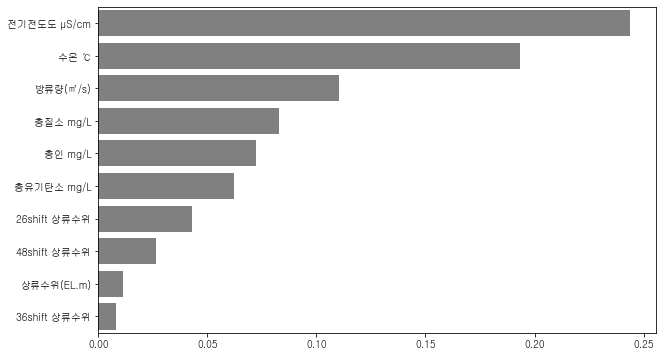

In [59]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [60]:
feature_series[:10]

전기전도도 μS/cm     0.243557
수온 ℃            0.193189
방류량(㎥/s)        0.110308
총질소 mg/L        0.082704
총인 mg/L         0.072414
총유기탄소 mg/L      0.062350
26shift 상류수위    0.043195
48shift 상류수위    0.026375
상류수위(EL.m)      0.011155
36shift 상류수위    0.008319
dtype: float64

In [61]:
print('score :', estimator.score(X_test, np.log1p(y_test)))

score : 0.9622440790268818


피처 정규화

In [62]:
scaler = StandardScaler()
scaler.fit(scb_df.loc[:, col_v])
scb_scaled = scaler.transform(scb_df.loc[:, col_v])

scb_df_scaled = pd.DataFrame(data = scb_scaled, columns = col_v)

In [63]:
scb_df_scaled.head()

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,상류수위(EL.m),방류량(㎥/s),1shift 상류수위,2shift 상류수위,3shift 상류수위,...,39shift 상류수위,40shift 상류수위,41shift 상류수위,42shift 상류수위,43shift 상류수위,44shift 상류수위,45shift 상류수위,46shift 상류수위,47shift 상류수위,48shift 상류수위
0,-0.625427,-0.567492,-1.099594,0.207057,-0.375331,0.722272,-0.173845,0.722255,0.724404,0.723303,...,0.718348,0.71833,0.718313,0.718295,0.718278,0.718261,0.718243,0.718226,0.718209,0.718191
1,-0.642856,-0.578842,-1.166677,0.198992,-0.360653,0.725522,-0.165679,0.722255,0.722237,0.724386,...,0.718348,0.71833,0.718313,0.718295,0.718278,0.718261,0.718243,0.718226,0.718209,0.718191
2,-0.629784,-0.522092,-1.066053,0.178325,-0.345975,0.726605,-0.142030,0.725505,0.722237,0.722220,...,0.718348,0.71833,0.718313,0.718295,0.718278,0.718261,0.718243,0.718226,0.718209,0.718191
3,-0.629784,-0.510742,-1.066053,0.184878,-0.331297,0.721189,-0.147522,0.726588,0.725487,0.722220,...,0.718348,0.71833,0.718313,0.718295,0.718278,0.718261,0.718243,0.718226,0.718209,0.718191
4,-0.655927,-0.510742,-1.166677,0.179838,-0.345975,0.719023,-0.153935,0.721172,0.726570,0.725470,...,0.718348,0.71833,0.718313,0.718295,0.718278,0.718261,0.718243,0.718226,0.718209,0.718191


In [64]:
X_trains, X_tests, y_trains, y_tests = train_test_split(scb_df_scaled.loc[:, col_v], scb_df['클로로필-a mg/㎥'], random_state=42)
gb_regs = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [65]:
gb_grids = GridSearchCV(gb_regs, param_grid=parameters, cv=3)

In [66]:
gb_grids.fit(X_trains, np.log1p(y_trains))

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]})

In [67]:
scores_dfs = pd.DataFrame(gb_grids.cv_results_)

In [68]:
scores_dfs.sort_values(by=['rank_test_score'], inplace=True)
scores_dfs[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.940393,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.939162,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.937910,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.935253,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.926460,5


In [69]:
gb_grids.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [70]:
estimators = gb_grids.best_estimator_

In [71]:
preds = estimators.predict(X_tests)

In [72]:
for score, name in zip(estimators.feature_importances_, col_v):
    print(round(score, 2), name)

0.19 수온 ℃
0.24 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.01 상류수위(EL.m)
0.11 방류량(㎥/s)
0.0 1shift 상류수위
0.01 2shift 상류수위
0.0 3shift 상류수위
0.0 4shift 상류수위
0.01 5shift 상류수위
0.0 6shift 상류수위
0.0 7shift 상류수위
0.01 8shift 상류수위
0.0 9shift 상류수위
0.0 10shift 상류수위
0.0 11shift 상류수위
0.0 12shift 상류수위
0.0 13shift 상류수위
0.0 14shift 상류수위
0.0 15shift 상류수위
0.0 16shift 상류수위
0.0 17shift 상류수위
0.0 18shift 상류수위
0.0 19shift 상류수위
0.0 20shift 상류수위
0.0 21shift 상류수위
0.0 22shift 상류수위
0.0 23shift 상류수위
0.0 24shift 상류수위
0.0 25shift 상류수위
0.04 26shift 상류수위
0.0 27shift 상류수위
0.0 28shift 상류수위
0.0 29shift 상류수위
0.0 30shift 상류수위
0.0 31shift 상류수위
0.0 32shift 상류수위
0.0 33shift 상류수위
0.0 34shift 상류수위
0.0 35shift 상류수위
0.01 36shift 상류수위
0.0 37shift 상류수위
0.0 38shift 상류수위
0.0 39shift 상류수위
0.0 40shift 상류수위
0.0 41shift 상류수위
0.0 42shift 상류수위
0.0 43shift 상류수위
0.0 44shift 상류수위
0.0 45shift 상류수위
0.01 46shift 상류수위
0.0 47shift 상류수위
0.03 48shift 상류수위


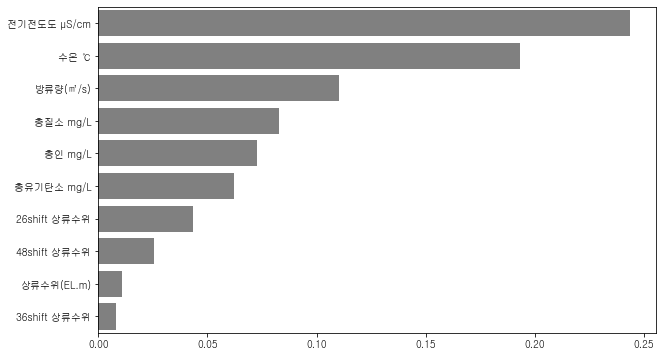

In [73]:
feature_seriess = pd.Series(data = estimators.feature_importances_, index = col_v)
feature_seriess = feature_seriess.sort_values(ascending = False)
sns.barplot(x = feature_seriess[:10], y = feature_seriess.index[:10], color = 'gray')
plt.show()

In [74]:
feature_seriess[:10]

전기전도도 μS/cm     0.243390
수온 ℃            0.193257
방류량(㎥/s)        0.110320
총질소 mg/L        0.082595
총인 mg/L         0.072757
총유기탄소 mg/L      0.062312
26shift 상류수위    0.043281
48shift 상류수위    0.025686
상류수위(EL.m)      0.010932
36shift 상류수위    0.008131
dtype: float64

In [75]:
print('score :', estimators.score(X_tests, np.log1p(y_tests)))

score : 0.9621561861409298
